In [1]:
import json
import pandas as pd
import re
import nltk
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from gensim.models import Doc2Vec
from tqdm import tqdm
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import spacy
from sklearn.ensemble import RandomForestClassifier

In [2]:
def clean_lyrics(lyrics):
    if lyrics is None:
        return lyrics
    
    # combine lists of tokens into single string
    lyrics = ' '.join(lyrics)
            
    # remove apostrophes
    lyrics = lyrics.replace('\'', '')
            
    # remove song structure tags or instructions in brackets
    lyrics = re.sub(r'[\*\[|\(|\{].*\n*.*[\]\)\}\*]' , ' ', lyrics)
   
    # remove variations of Verse 1, VERSE 2, etc...
    for verse in ['verse', 'VERSE', 'Verse']:
        lyrics = re.sub(verse+' \d*', '', lyrics)
    
    # some structure markers formatted as allcaps without brackets
    for word in ['OUTRO', 'INSTRUMENTAL', 'PRE', 'HOOK',
                 'PRODUCED', 'REFRAIN', 'POST', 'REPEAT', '2x', '3x', '4x',
                 'CHORUS', 'INTRO', 'INTERLUDE']:
        lyrics = lyrics.replace(word, '')
        
    # remove varations of Chorus
    lyrics = re.sub(r'\n*Chorus:*.*' , ' ', lyrics)
    lyrics = re.sub(r'^Chorus:*.*' , ' ', lyrics)
    lyrics = re.sub(r'\nRepeat [C|c]horus:*.*' , ' ', lyrics)
    
    # remove variations of Intro
    lyrics = re.sub(r'Intro[\s|\n|:].*', ' ', lyrics)
    
    # remove variations of Instrumental
    lyrics = re.sub(r'-+.*[i|I]nstrumental.*-+', ' ', lyrics)
    lyrics = re.sub(r'\nBrief instrumental.*\n', ' ', lyrics)
    lyrics = re.sub(r'\nInstrumental', ' ', lyrics)
    lyrics = re.sub(r'\nInstrumental break', ' ', lyrics)
    lyrics = re.sub(r'\nInstrumental--', ' ', lyrics)
    lyrics = re.sub(r'\n~Instrumental~', ' ', lyrics)
    
    # remove variations of Bridge
    lyrics = re.sub(r'\n\[*Bridge:\[*', ' ', lyrics)
    
    # remove variations of Hook
    lyrics = re.sub(r'Hook:.*', ' ', lyrics)
    
    # remove varations of Repeat
    lyrics = re.sub(r'Repeat\s.*', ' ', lyrics)
    lyrics = re.sub(r'\nRepeat$', ' ', lyrics)
    
    # remove credits
    lyrics = re.sub(r'.*[P|p]roduced [B|b]y.*', ' ', lyrics)
    lyrics = re.sub(r'.*[W|w]ritten [B|b]y.*', ' ', lyrics)
    
    # remove strays and typos
    lyrics = re.sub(r'\[Outro\[', ' ', lyrics)
    lyrics = re.sub(r'Sax & background & instrumental\)', ' ', lyrics)
    lyrics = re.sub(r'\nSource: ', ' ', lyrics)
    lyrics = re.sub(r'Shotgun 2: 58 Trk 1 \n  \nJr. Walker & The All Stars '\
                    +'\nAnd/or The Funk Brothers - instrumental \nPop Chart '\
                    +'#4 Feb 13, 1965 \nSoul Label - 35008   \n ', ' ', lyrics)
    lyrics = re.sub(r'- musical interlude -', ' ', lyrics)
    lyrics = re.sub(r'\nRefrain:', ' ', lyrics)
            
    # replace all punctuations with spaces
    lyrics = re.sub(r'[^\w\s]', ' ', lyrics)
            
    # replace consecutive whitespaces with single space
    lyrics = re.sub(r'\s+', ' ', lyrics)
    
    # convert all tokens to lowercase
    lyrics = lyrics.lower()

    if lyrics[:29] == 'we do not have the lyrics for' or lyrics == 'instrumental':
        lyrics = None
    return lyrics


In [3]:
with open('../data/top_hits_lyrics.json') as json_file:
    top_hits_lyrics = json.load(json_file)

In [4]:
top_hits_lyrics[0]

{'id': '1rfofaqEpACxVEHIZBJe6W',
 'lyrics': ['[Intro: Pharrell Williams]',
  '\nHey',
  '\n',
  '\n[Chorus: Camila Cabello & ',
  'Pharrell Williams',
  ']',
  '\n',
  'Havana, ooh na-na (',
  'Ayy',
  ')',
  '\nHalf of my heart is in Havana, ooh na-na (',
  'Ayy, ayy',
  ')',
  '\n',
  'He took me back to East Atlanta, na-na-na, ah',
  '\n',
  'Oh, but my heart is in Havana (',
  'Ayy',
  ')',
  "\nThere's somethin' 'bout his manners (",
  'Uh-huh',
  ')',
  '\n',
  'Havana, ooh na-na (',
  'Uh',
  ')',
  '\n',
  '\n[Verse 1: Camila Cabello & ',
  'Pharrell Williams',
  ']',
  '\n',
  'He didn\'t walk up with that "how you doin\'?" (',
  'Uh',
  ')',
  '\nWhen he came in the room',
  "\nHe said there's a lot of girls I can do with (",
  'Uh',
  ')',
  "\nBut I can't without you",
  '\nI knew him forever in a minute (',
  'Hey',
  ')',
  '\nThat summer night in June',
  '\n',
  'And papa says he got malo in him (',
  'Uh',
  ')',
  "\nHe got me feelin' like...",
  '\n',
  '\n[Pre-Choru

In [5]:
top_hits_df = pd.DataFrame(top_hits_lyrics)
top_hits_df['clean_lyrics'] = top_hits_df['lyrics'].apply(lambda x: clean_lyrics(x))
top_hits_df = top_hits_df[top_hits_df['source'].notnull()]
top_hits_df = top_hits_df[top_hits_df['clean_lyrics'].notnull()]

In [6]:
top_hits_df.shape

(2805, 4)

In [7]:
with open('../data/songs_lyrics_5000.json') as json_file:
    not_hits_1 = json.load(json_file)

In [8]:
with open('../data/songs_lyrics_10000.json') as json_file:
    not_hits_2 = json.load(json_file)

In [9]:
not_hits_lyrics = not_hits_1 + not_hits_2

In [10]:
with open('../data/not_hits_lyrics.json', 'w') as f:
        json.dump(not_hits_lyrics, f)

In [11]:
not_hits_df = pd.DataFrame(not_hits_lyrics)
not_hits_df['clean_lyrics'] = not_hits_df['lyrics'].apply(lambda x: clean_lyrics(x))
not_hits_df = not_hits_df[not_hits_df['source'].notnull()]
not_hits_df = not_hits_df[not_hits_df['clean_lyrics'].notnull()]

In [12]:
not_hits_df.shape

(7937, 4)

In [13]:
# TODO: stratified sampling by decade
not_hits_df = not_hits_df.sample(n=top_hits_df.shape[0])

In [14]:
not_hits_df.shape

(2805, 4)

In [15]:
print(not_hits_df['clean_lyrics'].iloc[0])

 a teenage dreams so hard to beat every time she walks down the street another girl in the neighbourhood wish she was mine she looks so good i wanna hold her wanna hold her tight get teenage kicks right through the night im gonna call her on the telephone have her over cos im all alone i need excitement oh i need it bad and its the best ive ever had i wanna hold her wanna hold her tight get teenage kicks right through the night a teenage dreams so hard to beat every time she walks down the street another girl in the neighbourhood wish she was mine she looks so good i wanna hold her wanna hold her tight get teenage kicks right through the night im gonna call her on the telephone have her over cos im all alone i need excitement oh i need it bad and its the best ive ever had i wanna hold her wanna hold her tight get teenage kicks right through the night i wanna hold her wanna hold her tight get teenage kicks right through the night


In [16]:
top_hits_df['class'] = 1
not_hits_df['class'] = 0
df = pd.concat([top_hits_df, not_hits_df])

In [28]:
df.head()
df.to_csv(r'C:\Users\Marty\switchdrive\M1\Data Mining and\data\File Name.csv')

# Most redundant words

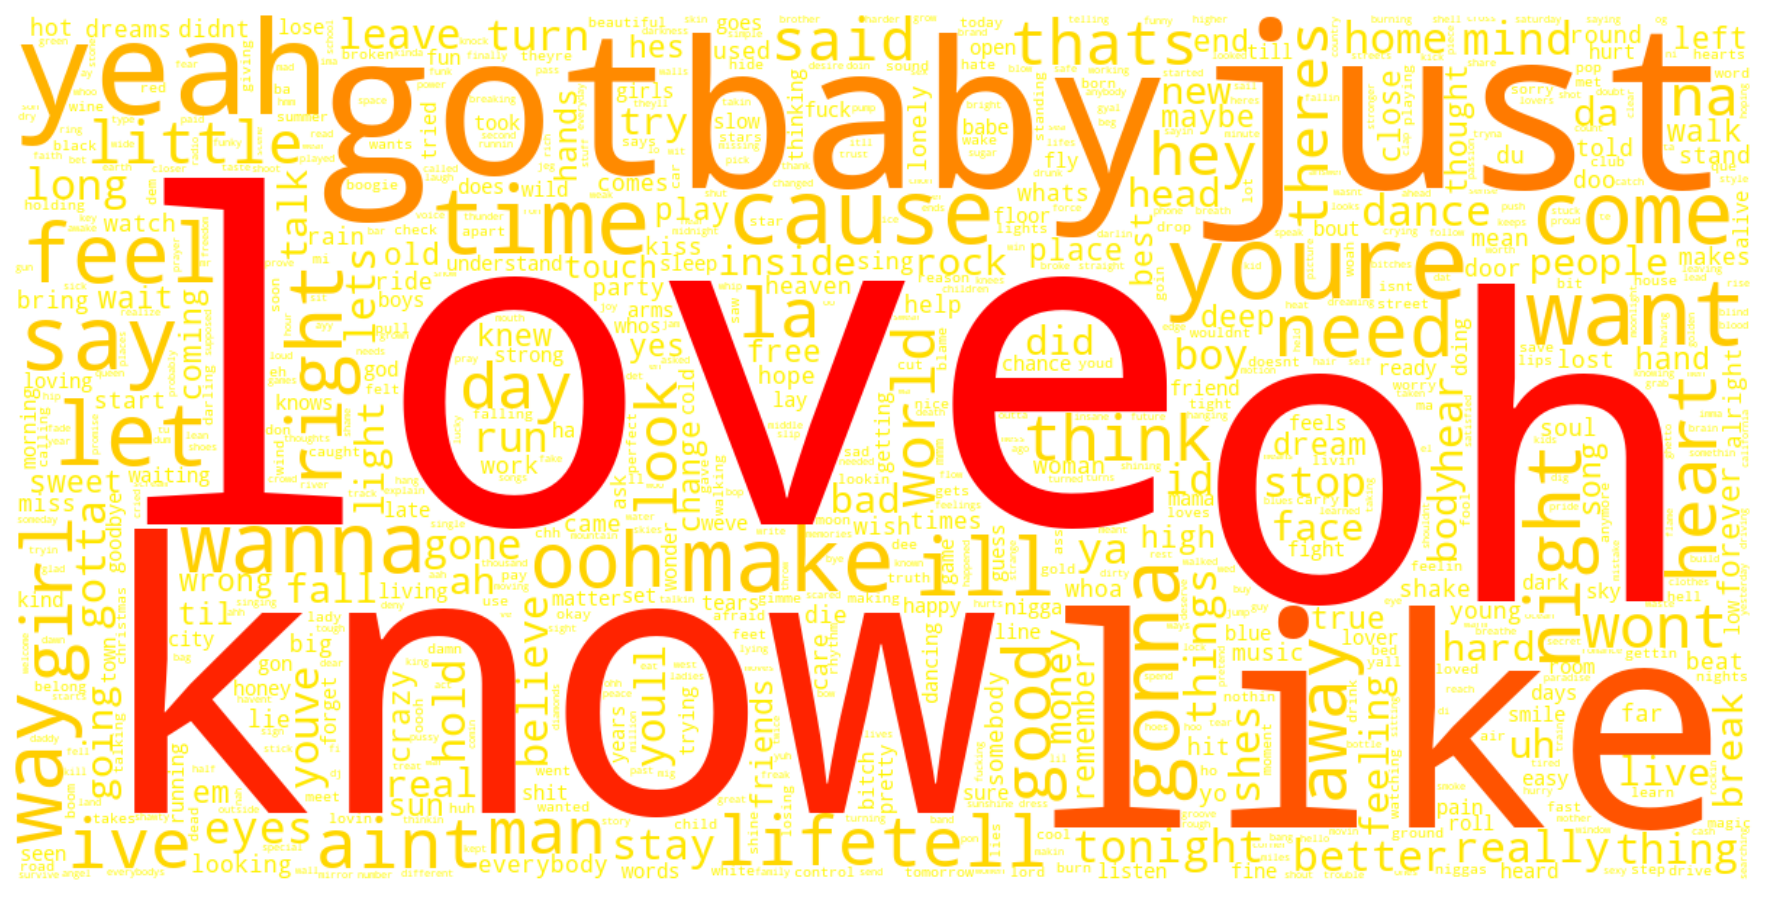

In [31]:
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt

#lyrics = df['clean_lyrics'].dropna().values.tolist()
#open('../data/not_hits_merged_clean_lyrics_audio_features.json') as
#with open('../data/not_hits_merged_clean_lyrics_audio_features.json') as json_file:
#    Data = json.load(json_file)       
#lyrics = Data['clean_lyrics'].dropna().values.tolist()    
#lyrics = pd.DataFrame(merged)
#lyrics = pd.read_json ('../data/not_hits_merged_clean_lyrics_audio_features.json')

#json = pd.read_json('../data/not_hits_merged_clean_lyrics_audio_features.json', lines=True)
#lyrics = json['clean_lyrics'].dropna().values.tolist() 

dfff = pd.read_csv("File Name.csv") 
lyrics = dfff['clean_lyrics'].dropna().values.tolist()

# when creating word clouds, maps word fontsize to a color
class colormap_size_func(object):
    def __init__(self, colormap, max_font_size):
        import matplotlib.pyplot as plt
        self.colormap = plt.cm.get_cmap(colormap)
        self.max_font_size = max_font_size

    def __call__(self, word, font_size, position, orientation,
                 random_state=None, **kwargs):
        if random_state is None:
            random_state = Random()
        r, g, b, _ = 255 * np.array(self.colormap(font_size / self.max_font_size))
        return "rgb({:.0f}, {:.0f}, {:.0f})".format(r, g, b)
    
# calculate word frequencies
stop_words = list(ENGLISH_STOP_WORDS) + ['im', 'dont']
count = CountVectorizer(stop_words=stop_words)
count.fit(np.array(lyrics))
freqs = np.array(count.transform(np.array(lyrics)).todense()).sum(axis=0)

# make word cloud
word_freq_dict = dict(zip(count.get_feature_names(), freqs))
wordcloud = WordCloud(background_color='white', height=600, min_font_size=2, width=1200, color_func=colormap_size_func('autumn_r', 300), max_words=800)
wordcloud = wordcloud.generate_from_frequencies(word_freq_dict)

# display word cloud
plt.figure(figsize=(16,8))
ax = plt.gca()
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off');


In [35]:
dfff = pd.read_csv("File Name.csv") 
dfff.head()

,Unnamed: 0,id,lyrics,source,clean_lyrics,class
0,0,1rfofaqEpACxVEHIZBJe6W,"['[Intro: Pharrell Williams]', '\nHey', '\n', ...",genius.com,hey half of my heart is in havana ooh na na h...,1
1,1,6rPO02ozF3bM7NnOV4h6s2,"['[Letra de ""Despacito"" ft. Daddy Yankee]', '\...",genius.com,ay fonsi d y ohhh oh no oh no oh hey yeah did...,1
2,2,7mldq42yDuxiUNn08nvzHO,"['[Verse 1]', '\n', 'Got a girl from the south...",genius.com,got a girl from the south side got braids in ...,1
3,3,1bhUWB0zJMIKr9yVPrkEuI,"['[Verse 1: Ed Sheeran]', '\n', 'I found a lov...",genius.com,i found a love for me oh darling just dive ri...,1
4,4,7iDa6hUg2VgEL1o1HjmfBn,"['[Verse 1: Florida Georgia Line]', '\nBaby, l...",genius.com,baby lay on back and relax kick your pretty f...,1


# Audio Features

In [36]:
with open('../data/top_hits.json') as json_file:
    top_hits = json.load(json_file)

In [37]:
top_hits_songs_df = pd.DataFrame(top_hits)

In [38]:
top_hits_merged_df = pd.merge(top_hits_df, top_hits_songs_df, on='id', how='inner')

In [39]:
top_hits_merged_df.shape

(2805, 37)

In [40]:
with open('../data/songs.json') as json_file:
    not_hits = json.load(json_file)

In [41]:
not_hits_songs_df = pd.DataFrame(not_hits)

In [42]:
not_hits_merged_df = pd.merge(not_hits_df, not_hits_songs_df, on='id', how='inner')

In [43]:
not_hits_merged_df.shape


(2805, 37)

In [44]:
merged_df = pd.concat([top_hits_merged_df, not_hits_merged_df])

In [47]:
merged_df.head()
merged_df.to_csv(r'C:\Users\Marty\switchdrive\M1\Data Mining and\data\Lyrics+Features.csv')

In [57]:
dff = pd.read_csv("Lyrics+Features.csv") 
dff.head

<bound method NDFrame.head of       Unnamed: 0                      id  \
0              0  1rfofaqEpACxVEHIZBJe6W   
1              1  6rPO02ozF3bM7NnOV4h6s2   
2              2  7mldq42yDuxiUNn08nvzHO   
3              3  1bhUWB0zJMIKr9yVPrkEuI   
4              4  7iDa6hUg2VgEL1o1HjmfBn   
5              5  09IStsImFySgyp0pIQdqAc   
6              6  7qiZfU4dY1lWllzX7mPBI3   
7              7  0KKkJNfGyhkQ5aFogxQAPU   
8              8  6RUKPb4LETWmmr3iAEQktW   
9              9  7BKLCZ1jbUBVqRi2FVlTVw   
10            10  0pqnGHJpmpxLKifKRmU6WP   
11            11  50kpGaPAhYJ3sGmk6vplg0   
12            12  09CtPGIpYB4BrO8qb1RGsF   
13            13  1zi7xx7UVEFkmKfv06H8x0   
14            14  3CRDbSIZ4r5MsZ0YwxuEkn   
15            15  4sPmO7WMQUAf45kwMOtONw   
16            16  1i1fxkWeaMmKEB4T7zqbzK   
17            17  1WkMMavIMc4JZ8cfMmxHkI   
18            18  32OlwWuMpZ6b0aN2RZOeMS   
19            19  34gCuhDGsG4bRPIf9bb02f   
20            20  2JzZzZUQj3Qff7wapcbKjc   
21

In [ ]:
audio_features = ['acousticness', 'danceability',  'energy',
            'instrumentalness', 'liveness', 'loudness', 'mode',
            'speechiness', 'tempo', 'time_signature', 'valence']
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)

df = pd.DataFrame(columns=('features', 'words'))
tototo = merged_df.to_numpy()

i=0
for audio_feature in audio_features:
    f = open('../data/not_hits_merged_clean_lyrics_audio_features.json')
    num_words = 0
    all_text = ''
    for sentence in f.readlines():
        this_sentence = sentence
        num_words_this = len(this_sentence.split(" "))
        num_words += num_words_this

    df.loc[i] = (audio_feature, num_words)
    i+=1

ax = df.plot.bar(title='Number of Words for each audio_feature');
plt.show()

In [ ]:
audio_features = ['acousticness', 'danceability',  'energy',
            'instrumentalness', 'liveness', 'loudness', 'mode',
            'speechiness', 'tempo', 'time_signature', 'valence']

In [ ]:
X = merged_df[audio_features]
y = merged_df['class']
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3, random_state=72)

In [ ]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
predicted = classifier.predict(X_test)
print(" test Accuracy:",metrics.accuracy_score(y_test, predicted))

In [ ]:
X.head()

# Most Words

In [32]:
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec
from matplotlib import rcParams
from matplotlib.patches import Rectangle
from scipy.stats import relfreq
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.linear_model import RidgeCV, LogisticRegressionCV
from nltk.corpus import stopwords
from wordcloud import WordCloud


sns.set(context='poster', style='white')
rcParams['font.family'] = 'sans-serif'
rcParams['font.serif'] = 'arial'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

warnings.filterwarnings('ignore')

In [33]:

class colormap_size_func(object):
    def __init__(self, colormap, max_font_size):
        import matplotlib.pyplot as plt
        self.colormap = plt.cm.get_cmap(colormap)
        self.max_font_size = max_font_size

    def __call__(self, word, font_size, position, orientation,
                 random_state=None, **kwargs):
        if random_state is None:
            random_state = Random()
        r, g, b, _ = 255 * np.array(self.colormap(font_size / self.max_font_size))
        return "rgb({:.0f}, {:.0f}, {:.0f})".format(r, g, b)

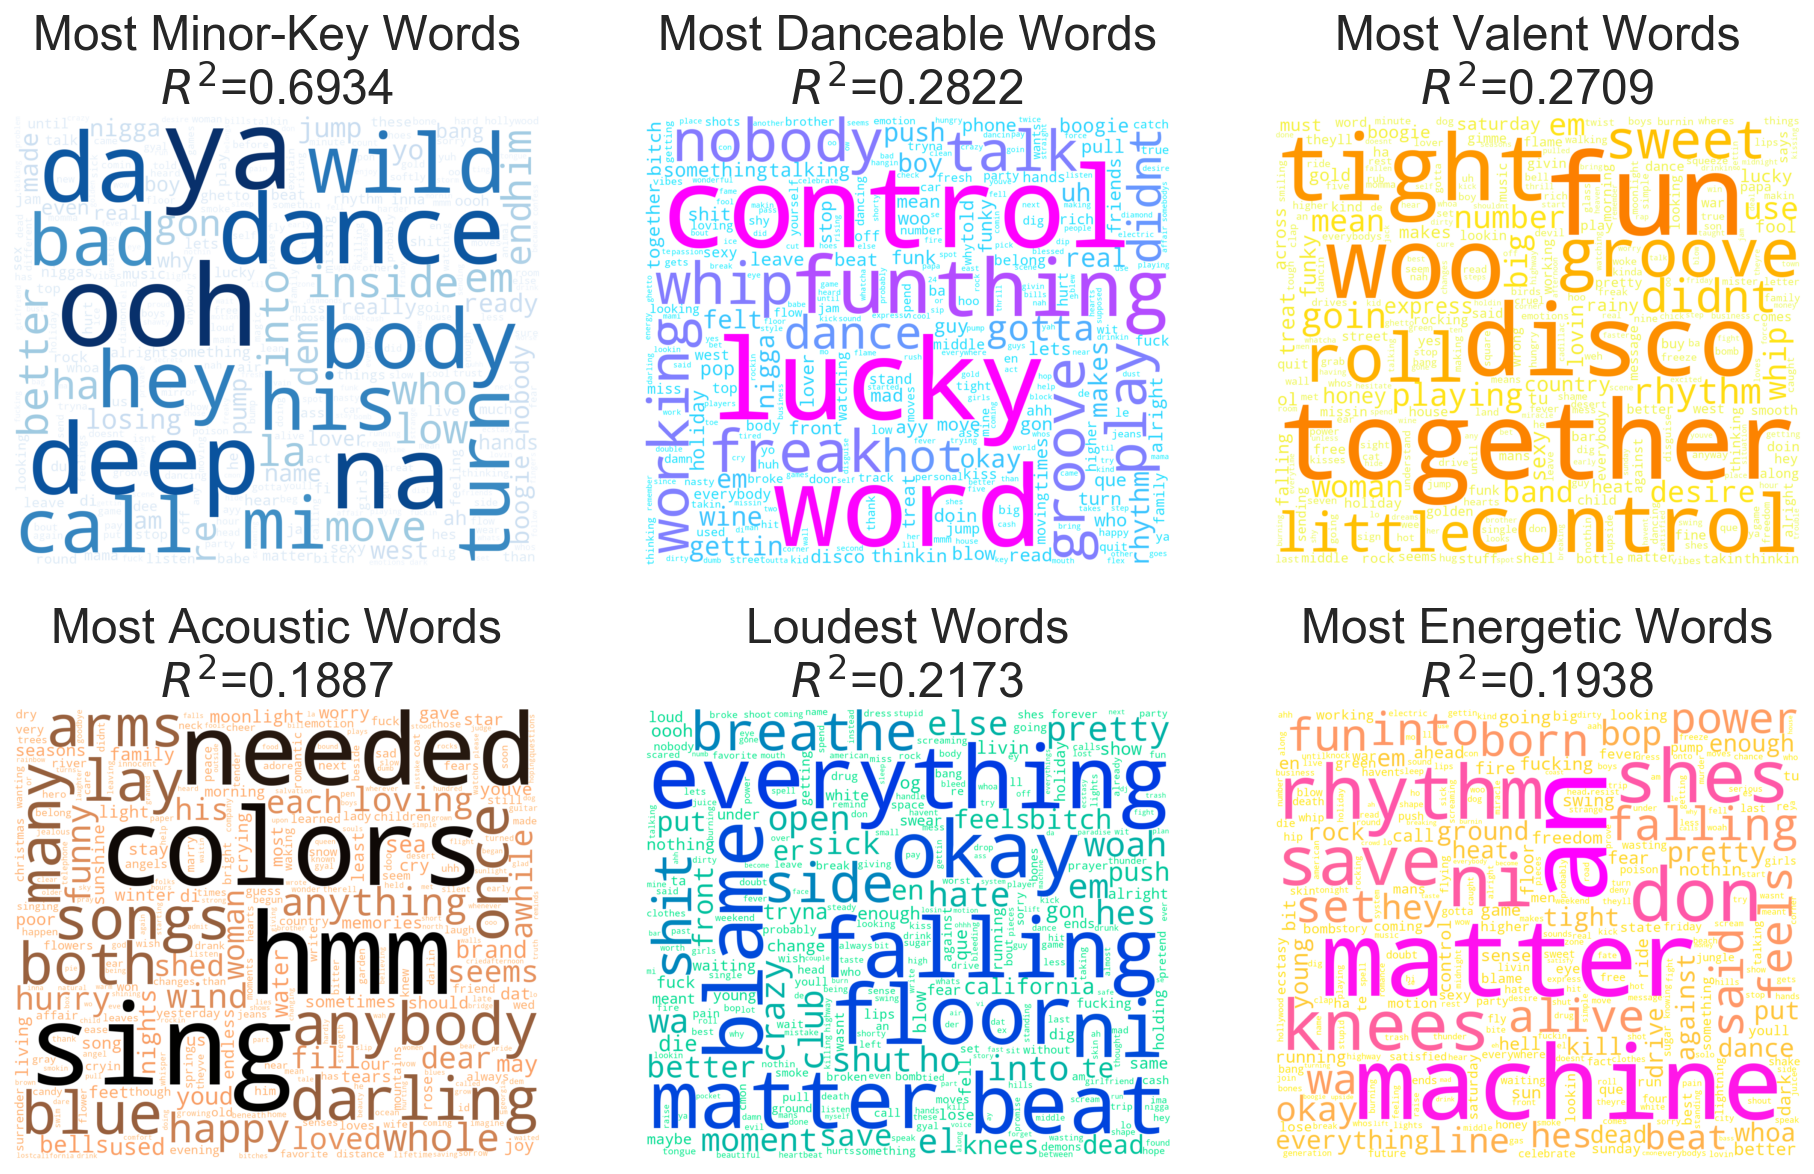

In [51]:
#df = pd.read_json('../data/not_hits_merged_clean_lyrics_audio_features.json', lines=True)
df_nonnull = pd.read_csv("Lyrics+Features.csv")  

fig, axes = plt.subplots(2, 3, figsize=(16,10))
axes = axes.ravel()
audio_features = ['mode', 'danceability', 'valence', 'acousticness',
                  'loudness', 'energy']
titles = ['most minor-key words', 'most danceable words', 'most valent words',
          'most acoustic words', 'loudest words', 'most energetic words']

cmaps = ['Blues', 'cool', 'Wistia', 'copper_r', 'winter_r', 'spring_r']

count = CountVectorizer(min_df=20, max_df=1000)
X_vect = count.fit_transform(df_nonnull['clean_lyrics'])
for i, feature in enumerate(audio_features):
    if feature != 'mode':
        ridge = RidgeCV(alphas=[1, 3, 10, 30, 1e2, 3e2, 1e3, 2e3, 3e3, 4e3, 1e5,
                                3e5, 1e6])
        ridge.fit(X_vect, df_nonnull[feature])
        score = ridge.score(X_vect, df_nonnull[feature])
    else:
        ridge = LogisticRegressionCV(Cs=[1e-6, 3e-6, 1e-5, 3e-5])
        ridge.fit(X_vect, 1 - df_nonnull[feature])
        score = ridge.scores_[1.].mean(axis=1).max()
    coefs = ridge.coef_
    if feature == 'mode':
        coefs = coefs.squeeze()
    vocab = count.get_feature_names()

    color_func = colormap_size_func(cmaps[i], 300)
    dictionary = dict(zip(vocab, coefs))
    wordcloud = WordCloud(background_color='white', height=1200,
                          min_font_size=5, width=1400, color_func=color_func,
                          max_words=300, relative_scaling=0.5,
                          max_font_size=300)
    wordcloud = wordcloud.generate_from_frequencies(dictionary)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set(title='{}\n$R^2$={:.4}'.format(titles[i], score).title())

# Bag of Words

In [3]:
import json
import pandas as pd
import re
import nltk
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from gensim.models import Doc2Vec
from tqdm import tqdm
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import spacy
from sklearn.ensemble import RandomForestClassifier
import json
import requests
from bs4 import BeautifulSoup
import string
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from wordcloud import WordCloud
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
#nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [9]:
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)
df = pd.read_csv("Lyrics+Features.csv")
df['popularity'] = (df['popularity'] > 50).astype(int)
df['popularity'].head()

0      1
1      1
2      1
3      1
4      1
5      1
6      1
7      1
8      1
9      1
10     1
11     1
12     1
13     1
14     1
15     1
16     1
17     1
18     1
19     1
20     1
21     0
22     1
23     1
24     1
25     1
26     1
27     1
28     1
29     1
      ..
470    1
471    1
472    1
473    1
474    1
475    1
476    1
477    1
478    1
479    1
480    1
481    1
482    1
483    1
484    1
485    1
486    1
487    1
488    1
489    1
490    1
491    1
492    1
493    1
494    1
495    1
496    1
497    1
498    0
499    1
Name: popularity, Length: 500, dtype: int32

In [10]:
X = df['clean_lyrics'] # the features we want to analyze
ylabels = df['popularity'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3, random_state=72)

In [11]:
classifier = LogisticRegression(solver="lbfgs")

# Create pipeline using Bag of Words
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

# model generation
pipe.fit(X_train,y_train)

from sklearn import metrics
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print(" test Accuracy:",metrics.accuracy_score(y_test, predicted))
print(" Precision:",metrics.precision_score(y_test, predicted, average=None))
print(" Recall:",metrics.recall_score(y_test, predicted, average=None))

 test Accuracy: 0.6286393345216874
 Precision: [0.45217391 0.64158163]
 Recall: [0.08469055 0.94106642]


In [12]:
classifier = RandomForestClassifier(n_estimators=1000)

# Create pipeline using Bag of Words
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

# model generation
pipe.fit(X_train,y_train)

from sklearn import metrics
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print(" test Accuracy:",metrics.accuracy_score(y_test, predicted))
print(" Precision:",metrics.precision_score(y_test, predicted, average=None))
print(" Recall:",metrics.recall_score(y_test, predicted, average=None))

 test Accuracy: 0.6274509803921569
 Precision: [0.41772152 0.63778055]
 Recall: [0.05374593 0.95696913]


# Doc2Vec

In [14]:
train, test = train_test_split(df, test_size=0.3, random_state=42)
lemmatizer = WordNetLemmatizer() 

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(lemmatizer.lemmatize(word.lower()))
    return tokens

train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['clean_lyrics']), tags=[r['popularity']]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['clean_lyrics']), tags=[r['popularity']]), axis=1)

LookupError: ("\n**********************************************************************\n  Resource \x1b[93mpunkt\x1b[0m not found.\n  Please use the NLTK Downloader to obtain the resource:\n\n  \x1b[31m>>> import nltk\n  >>> nltk.download('punkt')\n  \x1b[0m\n  For more information see: https://www.nltk.org/data.html\n\n  Attempted to load \x1b[93mtokenizers/punkt/english.pickle\x1b[0m\n\n  Searched in:\n    - 'C:\\\\Users\\\\Marty/nltk_data'\n    - 'C:\\\\Users\\\\Marty\\\\Anaconda3\\\\nltk_data'\n    - 'C:\\\\Users\\\\Marty\\\\Anaconda3\\\\share\\\\nltk_data'\n    - 'C:\\\\Users\\\\Marty\\\\Anaconda3\\\\lib\\\\nltk_data'\n    - 'C:\\\\Users\\\\Marty\\\\AppData\\\\Roaming\\\\nltk_data'\n    - 'C:\\\\nltk_data'\n    - 'D:\\\\nltk_data'\n    - 'E:\\\\nltk_data'\n    - ''\n**********************************************************************\n", 'occurred at index 2067')

In [ ]:
train_tagged.values[1]

In [ ]:
cores = multiprocessing.cpu_count()

In [ ]:
model_dbow = Doc2Vec(dm=0, vector_size=100, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

In [ ]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [ ]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [ ]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))